Dependencies
===============

In [1]:
from __future__ import division

from IPython.display import *

from numpy import *; seterr(all="ignore")
from numpy import linalg
from numpy import random

%matplotlib notebook
from matplotlib.pyplot import *

import wish

import audio.wave as wave
from audio.filters import FIR, AR
import audio.frames
import audio.index; import nltk; nltk.download("timit")
from audio.lp import lp
from audio.quantizers import Quantizer

[nltk_data] Downloading package timit to /home/boisgera/nltk_data...
[nltk_data]   Package timit is already up-to-date!


In [2]:
df = 16000
dt = 1.0 / df

Sandbox
========

FIR
---

In [3]:
fir = FIR([0.0, 1.0])
fir([1,2,3,4,5])

array([0., 1., 2., 3., 4.])

## Linear Prediction

In [4]:
x = 4*[-1.0, 1.0]
#figure()
#plot(x, "k+"); grid()
lp(x,order=2)#, method="autocorrelation")

/home/boisgera/miniconda2/envs/audio/lib/python2.7/site-packages/audio/lp.py:244: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a_, _, _ ,_ = np.linalg.lstsq(A, b) # can't trust the residues (may be [])


array([0., 1.])

Audio Source (NLTK)
=============

In [5]:
utterances = audio.index.search(type=audio.index.Utterance)
utterance = utterances[16]
display(utterance)
data = utterance.audio
audio.wave.write(data, "voice.wav", df=16000)
Audio("voice.wav")

brush fires are common in the dry underbrush of nevada

In [6]:
for item in utterance:
    print type(item).__name__.lower() + ": " + str(item)

phone: h# (brush fires are common in the dry underbrush of nevada).
word: brush [b-r-ah-sh]
word: fires [f-ay-axr-z]
word: are [axr]
word: common [kcl-k-aa-m-ix-n]
word: in [ix-n]
word: the [dh-ix]
word: dry [dcl-d-r-ay]
phone: q (brush fires are common in the dry underbrush of nevada).
word: underbrush [ah-n-axr-bcl-b-r-ah-sh]
word: of [ax-v]
word: nevada [n-ax-v-aa-dx-ax]
phone: h# (brush fires are common in the dry underbrush of nevada).


In [7]:
audio.index.search("ey", type=audio.index.Phone)

   0. ey (away [ix-w-ey]).
   1. ey (taken [tcl-t-ey-kcl-k-ix-nx]).
   2. ey (spray [s-pcl-p-r-ey]).
   3. ey (exchanged [ix-kcl-s-sh-ey-n-zh]).
   4. ey (vaguely [v-ey-gcl-g-l-iy]).
   5. ey (make [m-ey-kcl-k]).
   6. ey (occasionally [ow-kcl-k-ey-zh-l-ix]).
   7. ey (monday [m-ah-n-d-ey]).
   8. ey (always [ao-l-w-ey-z]).
   9. ey (situation [s-ix-tcl-ch-uw-ey-sh-en]).
  10. ey (clay [kcl-k-l-ey]).
  11. ey (straightforward [s-tcl-t-r-ey-q-f-ao-w-axr-dx]).
  12. ey (rachel's [r-ey-tcl-ch-el-z]).
  13. ey (maybe [m-ey-bcl-b-iy]).
  14. ey (they [dh-ey]).
  15. ey (take [tcl-t-ey-kcl-k]).
  16. ey (traits [tcl-t-r-ey-tcl-s]).
  17. ey (today's [tcl-t-ix-dx-ey-z]).
  18. ey (made [m-ey-dx]).
  19. ey (arbitrate [q-aa-r-bcl-b-ix-tcl-t-r-ey-tcl-t]).
  20. ey (cases [kcl-k-ey-s-ix-z]).
  21. ey (straight [s-tcl-t-r-ey-tcl]).
  22. ey (play [pcl-p-l-ey]).
  23. ey (repainted [r-iy-pcl-p-ey-nx-ix-dcl]).
  24. ey (waste [w-ey-s-tcl-t]).
  25. ey (masquerade [m-ae-s-kcl-k-axr-r-ey-dcl]).
  26.

In [8]:
data = wave.read("sounds/whisper.wav")[0]
Audio("sounds/whisper.wav")

In [9]:
audio.wave.write(data, "voice.wav", df=16000)

Short-Term Prediction
======================

In [10]:
class STP(Quantizer):
    "Short-Term Predictor"
    def __init__(self, order=16, method="autocorrelation"):
        self.fir = FIR(a=r_[1.0, zeros(order)]) 
        self.ar  = AR(a=zeros(order))
        self.order = order
        self.method = method
    def encode(self, data):
        if self.method == "covariance" and self.order >= len(data):
            raise ValueError("not enough data samples")
        a = lp(data, order=self.order, method=self.method)
        self.fir.a[:] = r_[1.0, -a]
        error = self.fir(data)
        return (a, error) 
    def decode(self, data):
        a, error = data
        self.ar.a[:] = a
        return self.ar(error)

In [11]:
def stp_error(data, T=0.02, order=16, method="autocorrelation"):
    length = len(data)
    n = int(T * df) # number of samples for T s at the given frequency.
    frames = audio.frames.split(data, n, pad=True)
    stp = STP(order=order, method=method)
    error = zeros(n*len(frames))
    for i, frame in enumerate(frames):
        a, error_frame = stp.encode(frame)
        error[i*n:(i+1)*n] = error_frame
    return error[:length]

<IPython.core.display.Javascript object>


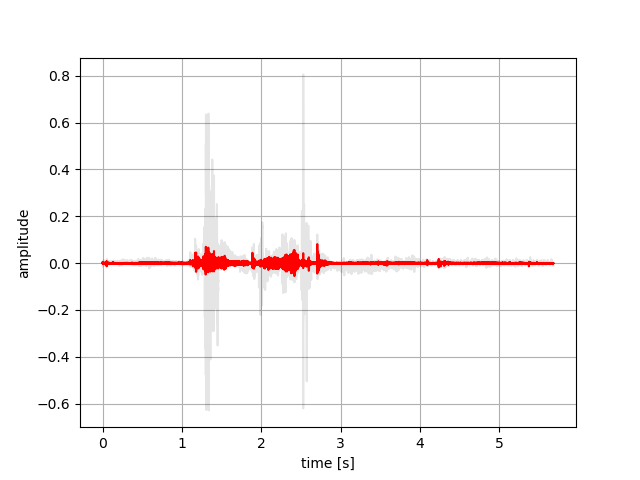

In [12]:
figure()    
n = len(data)
t = r_[0:n] / df
plot(t,data, "k", alpha=0.1); axis("tight")
error = stp_error(data)
plot(t,error, "r")
xlabel("time [s]")
ylabel("amplitude")
axis("tight")
grid()

In [13]:
display(utterance[2])
phone = utterance[2][1]
display(phone)
start, end = phone.span
display(start, end)

fires [f-ay-axr-z]

ay (fires [f-ay-axr-z]).

6781

9315

SNR 20.299399909750694 dB


<IPython.core.display.Javascript object>


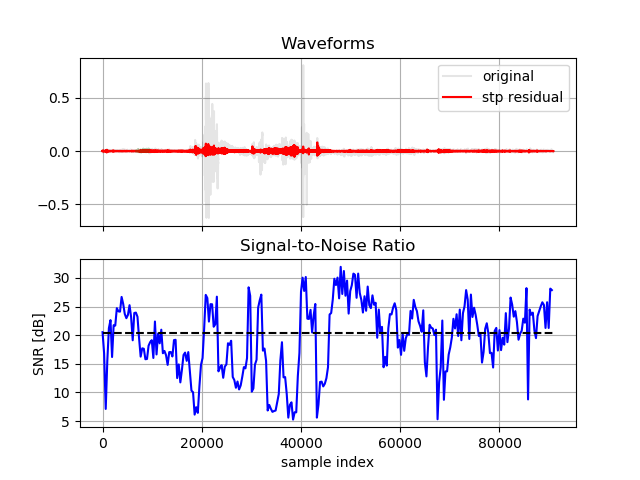

In [14]:
error = stp_error(data)
SNR2 = mean(data*data) / mean(error*error)
print "SNR", 10*log10(SNR2), "dB"

T = 20.0 / 1000 # 20 ms
n = int(df * T)
data_frames = audio.frames.split(data, n, pad=True)
error_frames = audio.frames.split(error, n, pad=True)

fig, (ax1, ax2) = subplots(2,1, sharex=True)
SNRs = [10.0 * log10(mean(d*d) / mean(e*e)) for d,e in zip(data_frames, error_frames)]
ax1.plot(data, "k", alpha=0.1, label="original")
ax1.plot(error, "r", label="stp residual")
ax1.set_title("Waveforms")
ax1.axis("tight")
ax1.legend()
ax1.grid()
ax2.plot(r_[0:len(SNRs)] * n,  SNRs, "b")
ax2.plot([0,len(data_frames)*n], [10*log10(SNR2), 10*log10(SNR2)], "k--")
ax2.set_xlabel("sample index")
ax2.set_ylabel("SNR [dB]")
ax2.set_title("Signal-to-Noise Ratio")
ax2.grid()
ax1.plot(r_[start:end-1],data[start:end-1], alpha=0.2,color="g")


In [15]:
error = error / amax(abs(error))
wave.write(error, "voice-error-stp.wav", df=df)
display(Audio("voice.wav"))
display(Audio("voice-error-stp.wav"))

Pitch Estimation
==========

In [16]:
def ltp_parameters(history, frame,
                   offset_min=1, offset_max=None,
                   gain_min=0.0, gain_max=inf,
                   SNR_min=1.0, SNR_max=inf,
                   select=argmax,
                   returns="offset, gain"):
    p = len(history)
    data = r_[history, frame] # full data
    m = len(frame)
    n = len(data)
    nxcorrs = zeros(p+1)
    gains = zeros(p+1)
    SNRs = zeros(p+1)
    valids = zeros(p+1, dtype=bool)
    frame_norm = linalg.norm(frame)
    normed_frame = frame / frame_norm
    for i in range(p + 1):
        windowed_data = data[n-i-m:n-i]
        windowed_data_norm = linalg.norm(windowed_data)
        normed_windowed_data = windowed_data / windowed_data_norm
        nxcorr = nxcorrs[i] = dot(normed_frame, normed_windowed_data)
        SNR = SNRs[i] = 1.0 / sqrt(1 - nxcorr*nxcorr)
        #print ">", SNR
        gain = gains[i] = nxcorr / windowed_data_norm * frame_norm
        valid = True
        if offset_min is not None:
            valid = valid and (offset_min <= i)
        if offset_max is not None:
            valid = valid and (i <= offset_max)
        valid = valid and (gain_min <= gain <= gain_max)
        valid = valid and (SNR_min <= SNR <= SNR_max)
        valids[i] = valid

    criteria = SNRs.copy() 
    criteria[logical_not(valids)] = -inf
    offset = select(criteria)
    if not valids[offset]: # everything is invalid!
        raise ValueError("no valid set of parameters")
    else:
        gain = gains[offset]
        nxcorr = nxcorrs[offset]
        SNR = SNRs[offset]

    return wish.grant(returns)

offset: 25 gain: 1.061276723494138


<IPython.core.display.Javascript object>


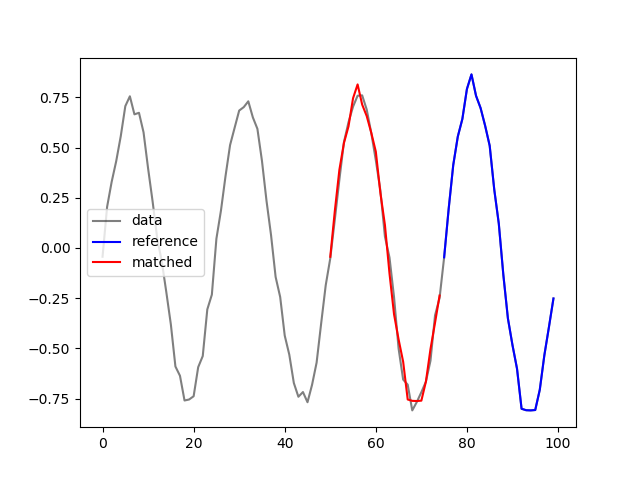

In [17]:
N = 100
data_ = (0.7 * sin(r_[0:N]/N * 2*pi*4) + 0.05 * random.uniform(-1,1,N)) * (1.0 + 0.2*r_[0:1:1.0/N])
#history[::7] = 1.0
history, frame = data_[:-25], data_[-25:]
m = len(history)
n = len(frame)
offset_min = 5
def select(factor):
    def _select(SNRs):
        i = argmax(SNRs)
        is_ = r_[0:len(SNRs)]
        SNRi = max(SNRs)
        js = [int(ceil(i/2.0)), int(floor(i/2.0)), int(ceil(i/3.0)), int(floor(i/3.0)), int(ceil(i/4.0)), int(floor(i/4.0))]
        ij = argmax(SNRs[js])
        if SNRs[js[ij]] >= factor * SNRi:
            return js[ij]
        else:
            return i
    return _select
offset, gain, nxcorrs, SNRs, valids = ltp_parameters(history, frame, 
                                                     offset_min=offset_min, SNR_min=1.0, select=select(0.5),
                                                     returns="offset, gain, nxcorrs, SNRs, valids")
print "offset:", offset, "gain:", gain

figure()
plot(data_, "k", alpha=0.5, label="data")
plot(arange(0,n)+m, frame, "b", label="reference")
plot(arange(m-offset, m-offset+n), frame/gain, "r", label="matched")
axis("tight")
legend(loc=0)

<IPython.core.display.Javascript object>


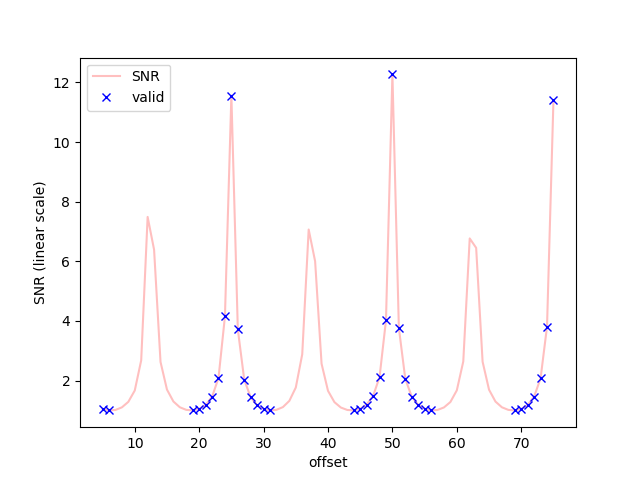

In [18]:
figure()
m = arange(len(SNRs))
plot(m[offset_min:],SNRs[offset_min:], "r", alpha=0.25, label="SNR")
n = arange(len(SNRs))
plot(n[valids],SNRs[valids], "bx", linewidth=1.0,label="valid")
xlabel("offset")
ylabel("SNR (linear scale)")
axis("tight")
legend(loc=0)

Long-Term Prediction
====================

In [19]:
class LTP(Quantizer):
    def __init__(self, order, **options):
        self.fir = FIR(a=r_[1.0, zeros(order)])
        self.history = zeros(order)
        self.ar = AR(a=zeros(order))
        self.order = order
        self.options = options
    def encode(self, frame):
        a = zeros_like(self.fir.a)
        a[0] = 1.0
        try:
            offset, gain = ltp_parameters(self.history, frame, **self.options)
            a[offset] = - gain
        except ValueError:
            offset, gain = 0, 0.0
        self.fir.a[:] = a 
        error = self.fir(frame)
        self.history = r_[self.history[len(frame):], frame]
        return (offset, gain), error
    def decode(self, data):
        (offset, gain), error = data
        a = zeros_like(self.ar.a)
        a[offset-1] = gain
        self.ar.a[:] = a
        return self.ar(error)

In [20]:
f_min = 50.0
f_max = 400.0
order_ltp = int(df/f_min)
print order_ltp
offset_min = int(df/f_max)
print offset_min

320
40


In [21]:
def ltp_error(data, T=0.005, order=order_ltp, **options):
    length = len(data)
    n = int(T * df) # number of samples for T s at the given sampling frequency.
    frames = audio.frames.split(data, n, pad=True)
    ltp = LTP(order=order, **options)
    error = zeros(n*len(frames))
    offset = zeros_like(error)
    gain = zeros_like(error)
    for i, frame in enumerate(frames):
        (offset_, gain_), error_frame = ltp.encode(frame)
        error[i*n:(i+1)*n] = error_frame
        offset[i*n:(i+1)*n] = ones_like(error_frame) * offset_
        gain[i*n:(i+1)*n] = ones_like(error_frame) * gain_
    error = error[:length]
    offset = offset[:length]
    gain = gain[:length]
    return error, offset, gain

<IPython.core.display.Javascript object>


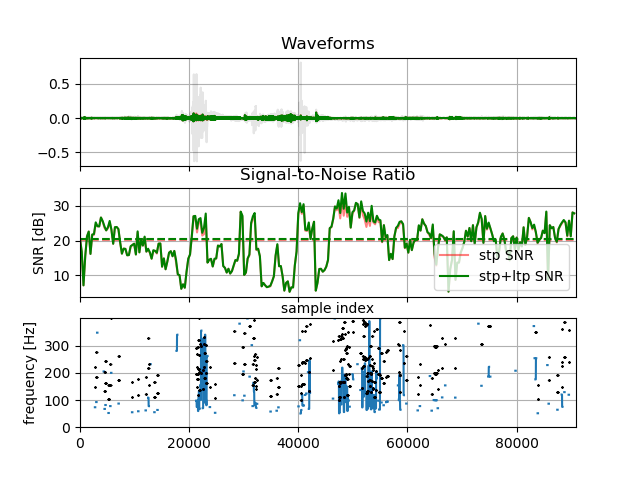

In [22]:
stp_error_ = stp_error(data)
ltp_error_, offset, gain = ltp_error(stp_error_, offset_min=offset_min, SNR_min=1.1, select=select(0.5))
stp_SNR2 = mean(data*data) / mean(stp_error_*stp_error_)
ltp_SNR2 = mean(data*data) / mean(ltp_error_*ltp_error_)

T = 20.0 / 1000 # 20 ms
n = int(df * T)
data_frames = audio.frames.split(data, n, pad=True)
stp_error_frames = audio.frames.split(stp_error_, n, pad=True)
ltp_error_frames = audio.frames.split(ltp_error_, n, pad=True)


fig, (ax1, ax2, ax3) = subplots(3,1, sharex=True)
stp_SNRs = [10.0 * log10(mean(d*d) / mean(e*e)) for d,e in zip(data_frames, stp_error_frames)]
ltp_SNRs = [10.0 * log10(mean(d*d) / mean(e*e)) for d,e in zip(data_frames, ltp_error_frames)]
ax1.plot(data, "k", alpha=0.1, label="original")
ax1.plot(stp_error_, "r", alpha=0.5, label="stp residual")
ax1.plot(ltp_error_, "g", alpha=1.0, label="stp+ltp residual")
ax1.set_title("Waveforms")
ax1.axis("tight")
#ax1.legend()
ax1.grid()
ax2.plot(r_[0:len(stp_SNRs)] * n,  stp_SNRs, "r", alpha=0.5, label="stp SNR")
ax2.plot([0,len(data_frames)*n], [10*log10(stp_SNR2), 10*log10(stp_SNR2)], "r--", alpha=0.5)
ax2.plot(r_[0:len(ltp_SNRs)] * n,  ltp_SNRs, "g", label="stp+ltp SNR")
ax2.plot([0,len(data_frames)*n], [10*log10(ltp_SNR2), 10*log10(ltp_SNR2)], "g--")
ax2.set_xlabel("sample index")
ax2.set_ylabel("SNR [dB]")
ax2.set_title("Signal-to-Noise Ratio")
ax2.legend()
ax2.grid()
#n = len(data)
#t = r_[0:n] / df
ax3.plot(df / offset)
ax3.plot(2*df / offset, "k.", alpha=0.5, ms=0.25)
ax3.plot(3*df / offset, "k.", alpha=0.25, ms=0.25)
ax3.axis([0, len(data), 0, 400.0])
ax3.set_ylabel("frequency [Hz]")
ax3.set_yticks(r_[0:400:100])
ax3.grid()

In [23]:
ltp_error_ = ltp_error_ / amax(abs(ltp_error_))
wave.write(ltp_error_, "voice-error-stp-ltp.wav", df=df)
display(Audio("voice.wav"))
display(Audio("voice-error-stp.wav"))
display(Audio("voice-error-stp-ltp.wav"))